**Recurrent Neural Networks with Long Short Term Memory Units for Time Series Predictions and Imputations Test - 19 Nov (Testing Multivariate)**



1. Test on all Monday 24 hours data for Peachtree SB L_1 & Luckie WB L_1

In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
import math
print(tf.__version__)

2.0.0-dev20191002


In [3]:
dataset = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

#replace missing values y -10 to test if model will learn to not include these in these as missing values
dataset_w_missing = dataset.fillna(-10,inplace=True)
dataset = dataset[:-240]
#check

dataset=dataset[dataset['date_time'].str.contains("2/25/2019")==False]
print (dataset.iloc[49]['State-EB-L_1'])
#print (dataset.iloc[3359]['State-EB-L_1'])

-10.0


[41. 36. 28. ... 24. 15. 19.]
[[27. 41.]
 [62. 36.]
 [29. 28.]
 ...
 [15. 24.]
 [ 9. 15.]
 [20. 19.]]


(-15.100000000000001, 150)

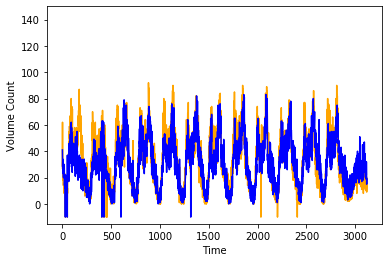

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("VolumeCount")
    plt.grid(False)

#extract State-EB-L_1 series 
series = dataset['Peachtree-SB-L_1'].values
series_output = dataset['Peachtree-SB-L_1'].values
print (series_output)
series_inputs = dataset[['Luckie-WB-L_1','Peachtree-SB-L_1']].values
print (series_inputs)
time = dataset['date_time'].values

time_num = [i for i in range(len(series))]
#plot_series(time_num, series)
# plot_series(time_num, series_inputs[:,0])
# plot_series(time_num, series_inputs[:,1])

plt.plot(time_num, series_inputs[:,0], color='orange')
plt.plot(time_num, series_inputs[:,1], color='blue')
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.ylim(top=150)

(-15.100000000000001, 150)

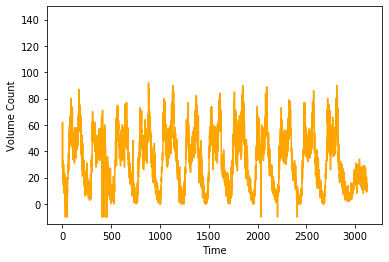

In [5]:
plt.plot(time_num, series_inputs[:,0], color='orange')
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.ylim(top=150)

(-14.65, 150)

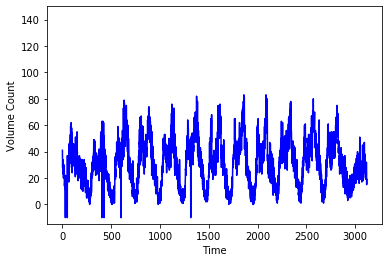

In [6]:
plt.plot(time_num, series_inputs[:,1], color='blue')
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.ylim(top=150)

**Split data into training and time**

**Define window_size, batch_size, and shuffle_buffer_size for modelling**

Window Size

batch Size

Shuffle uffer Size

In [7]:
num_days = 10
split_time = num_days*240
# time_train = time[:split_time]
# x_train = series[:split_time]
# time_valid = time[split_time:]
# x_valid = series[split_time:]

time_train = time[:split_time]
x_train = series_inputs[:split_time]
time_valid = time[split_time:]
x_valid = series_inputs[split_time:]

window_size = 100
batch_size = 30
shuffle_buffer_size = 100

**Creating windowed dataset**

Give explanation...



In [8]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    #series = series.astype(np.float64)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1][1]))
    dataset = dataset.batch(batch_size).prefetch(1)
#     print (dataset)
#     for window in dataset:
#         print (window[0].shape)
    return dataset
# for window in dataset:
#     print (window)
    #dataset = dataset.map(lambda window: (window[:-1], window[-1][1]))
#dataset = dataset.map(lambda window: (window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
# print (dataset)
    #print (dataset)
    #return dataset
# for window in dataset:
#     print (window[0].numpy())
    #print (window.numpy()[1])
    #dataset = dataset.batch(batch_size).prefetch(1)
    #print (dataset)
    #return dataset
# for window in dataset:
#     print (window[0].numpy())
#     print (window[1].numpy())
    #return dataset
# dataset = tf.data.Dataset.from_tensor_slices(series_output)
# # print (dataset)
# dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

# dataset = dataset.map(lambda window: (window[:-1], window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
# print (dataset)

# print (dataset)
# dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
  #return dataset


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(series_inputs)
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1][1]))
dataset = dataset.batch(batch_size).prefetch(3)
print (dataset)
for window in dataset:
    print (window[0].shape)

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#y = tf.cast(y, tf.float32)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print (dataset)
#dataset = tf.cast(dataset, tf.float64)

model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=None),
    #tf.keras.layers.Lambda(lambda x:tf.cast(x, tf.float64)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(batch_size, window_size,2))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),

  tf.keras.layers.Lambda(lambda x: x*100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])


In [ ]:
for window in dataset:
    print (window[0].numpy())
    print (window[1].numpy())

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(batch_size, window_size,2))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),

  tf.keras.layers.Lambda(lambda x: x*100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=2e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

In [ ]:
model.save('peachtree_sb_l1_multi_2.h5')

In [8]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('peachtree_sb_l1_multi_2.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  8960      
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  33600     
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  38720     
_________________________________________________________________
bidirectional_3 (Bidirection multiple                  28928     
_________________________________________________________________
dense (Dense)                multiple                  65        
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 110,273
Trainable params: 110,273
Non-trainable params: 0
__________________________________________________

(-15.0, 120)

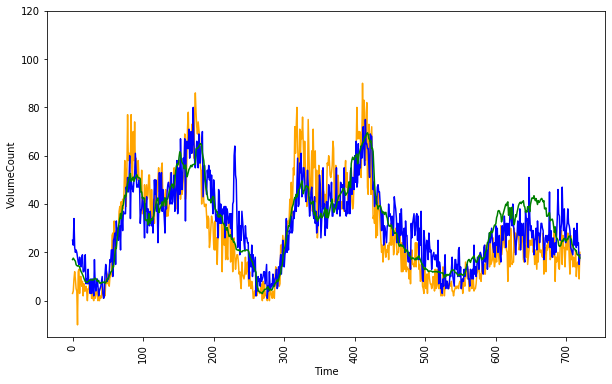

In [9]:
forecast = []
results = []
for time in range(len(series_inputs) - window_size):
    forecast.append(new_model.predict(series_inputs[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
time_valid = [i for i in range(len(time_valid))]
plt.plot(time_valid, x_valid[:,0], color='orange')
plt.plot(time_valid, x_valid[:,1], color='blue')
plt.plot(time_valid, results, color='green')
plt.xlabel("Time")
plt.ylabel("VolumeCount")
plt.grid(False)
plt.ylim(top=120)
# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid[:,1], results).numpy()

6.5913506

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid[:,0], results).numpy()

8.838318

In [12]:
mae = tf.keras.metrics.mean_absolute_error(x_valid[:,1], results).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid[:,1], results).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid[:,1], results).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid[:,1] - results)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 6.5913506
mean squared error: 71.60583
root mean squared error: 8.46202265014358
forecast_bias: -17.420059204101562
standard dev of errors: 8.461988236885901


## Forecast on Typical Day

In [13]:
typical_actuals = x_valid[:,1][:480]
typical_predictions = results[:480]
#print (typical_predictions)
mae = tf.keras.metrics.mean_absolute_error(typical_actuals, typical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (typical_actuals - typical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 6.0258727
mean squared error: 62.101734
root mean squared error: 7.880465351828974
forecast_bias: 481.79860496520996
standard dev of errors: 7.81627981460584


(-2.95, 120)

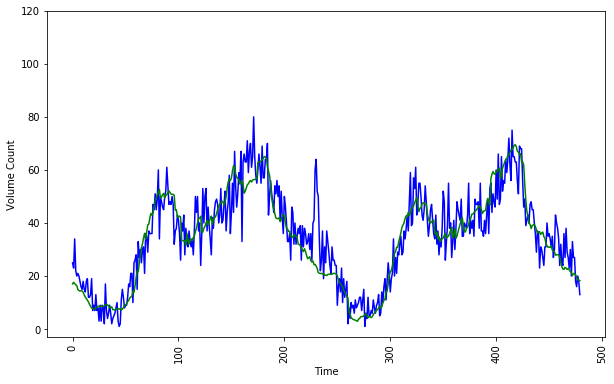

In [14]:
time_typical = [i for i in range(len(typical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_typical, typical_actuals, color = 'blue')
plt.plot(time_typical, typical_predictions, color = 'green')
plt.ylim(top=120)

## Forecast on Atypical Day

In [15]:
atypical_actuals = x_valid[:,1][-240:]
atypical_predictions = results[-240:]
#print (atypical_predictions)

mae = tf.keras.metrics.mean_absolute_error(atypical_actuals, atypical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (atypical_actuals - atypical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 7.7223053
mean squared error: 90.61401
root mean squared error: 9.519139334618178
forecast_bias: -499.2186641693115
standard dev of errors: 9.28909525379471


(0.5999999999999996, 120)

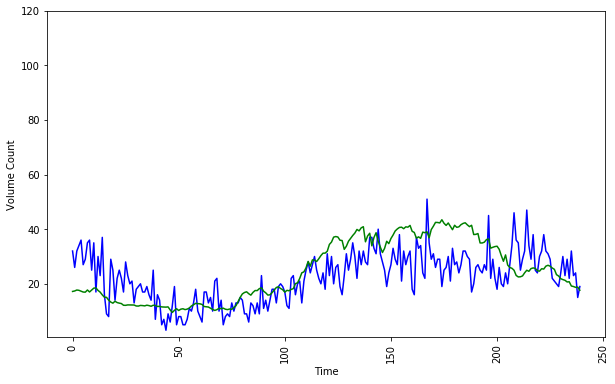

In [16]:
time_atypical = [i for i in range(len(atypical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_atypical, atypical_actuals, color = 'blue')
plt.plot(time_atypical, atypical_predictions, color = 'green')
plt.ylim(top=120)

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

(-15.0, 150)

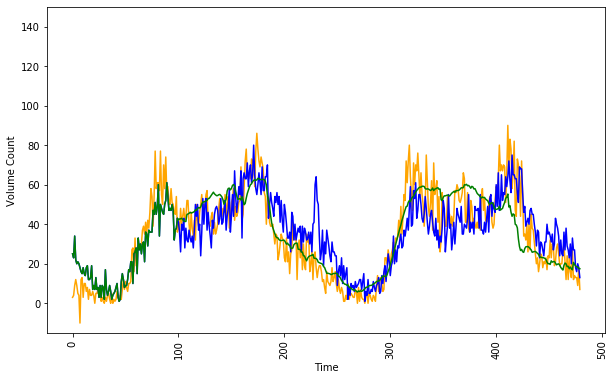

In [24]:
forecast = []
results = []

slice_val_time = 100
sliced_val_series = x_valid[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 380
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
    p = [[x_valid[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)


#forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
#print (sliced_val_series)

# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)

sliced_val_actual = x_valid[:slice_val_time+number_missing_units] 
sliced_val_times = time_valid[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=150)

#print (sliced_val_series)
# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series[:,1])
#print (sliced_val_series[:,1].shape)

In [19]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()

8.471500940124194

In [20]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,0], sliced_val_series[:,1]).numpy()

8.296691198150317

In [21]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 8.471500940124194
mean squared error: 139.6605244842037
root mean squared error: 11.81780540050494
forecast_bias: 201.72556734085083
standard dev of errors: 11.810330421835088


In [22]:
actuals = sliced_val_actual[:,1][-380:]
predictions = sliced_val_series[:,1][-380:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals - predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 10.700843292788456
mean squared error: 176.41329408530996
root mean squared error: 13.282066634575735
forecast_bias: 201.72556734085083
standard dev of errors: 13.271453770772405


## Different Time Slice

In [40]:
forecast = []
results = []
mae_array = []
rmse_array = []
std_array = []

for slice_val_time in range(100, 351, 10):
    #slice_val_time = 630
    sliced_val_series = x_valid[:slice_val_time]
    #print (sliced_val_series)
    #print (x_valid)

    number_missing_units = 120
    # print (sliced_val_series[-1][0])
    #forecasts only on validation part of time series
    #series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
    for t in range(number_missing_units):
        l=len(sliced_val_series)
        #print (sliced_val_series[(l-window_size):l])
       # print (t)
        #if t == 0: 
        forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
        #print (forecast)
        #else:
           # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
        p = [[x_valid[slice_val_time+t][0],forecast[-1][0][0]]]
        #print (p)
        sliced_val_series = np.append(sliced_val_series, p, axis=0)
        #print (sliced_val_series)


    #forecast = forecast[split_time-window_size:]

    #results = np.array(forecast)[:, 0, 0]
    #print (results)
    #print (sliced_val_series)

    # plt.figure(figsize=(10, 6))
    # plt.xticks(rotation=90)

    sliced_val_actual = x_valid[:slice_val_time+number_missing_units] 
    sliced_val_times = time_valid[:slice_val_time+number_missing_units]

    sliced_val_times = [i for i in range(len(sliced_val_times))]
    actuals_slice = sliced_val_actual[:,1][-number_missing_units:]
    predictions_slice = sliced_val_series[:,1][-number_missing_units:]

    mae = tf.keras.metrics.mean_absolute_error(actuals_slice, predictions_slice).numpy()
    print ("mean absolute error: "+ str(mae))
    mae_array.append(mae)
    mse = tf.keras.metrics.mean_squared_error(actuals_slice, predictions_slice).numpy()
    print ("mean squared error: "+ str(mse))
    rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_slice, predictions_slice).numpy())
    print ("root mean squared error: "+ str(rmse))
    rmse_array.append(rmse)
    array_of_errors = (actuals_slice - predictions_slice)
    forecast_bias = sum(array_of_errors)
    #print (array_of_errors)
    print ("forecast_bias: "+ str(forecast_bias))
    std_dev_errors = np.std(array_of_errors)
    print ("standard dev of errors: "+ str(std_dev_errors))
    std_array.append(std_dev_errors)


mean absolute error: 9.474765253067016
mean squared error: 129.1272126677932
root mean squared error: 11.36341553705545
forecast_bias: -66.14718818664551
standard dev of errors: 11.350037970785797
mean absolute error: 8.860792112350463
mean squared error: 120.0072633602413
root mean squared error: 10.95478267060745
forecast_bias: 263.9002323150635
standard dev of errors: 10.731771560067209
mean absolute error: 9.760377597808837
mean squared error: 151.70420305017427
root mean squared error: 12.316826013635747
forecast_bias: 400.7622833251953
standard dev of errors: 11.855408154633496
mean absolute error: 9.694650769233704
mean squared error: 155.31690164468426
root mean squared error: 12.462620175736893
forecast_bias: 607.9435796737671
standard dev of errors: 11.386419748789256
mean absolute error: 9.47896494070689
mean squared error: 149.38010889185455
root mean squared error: 12.222115565312519
forecast_bias: 701.4247426986694
standard dev of errors: 10.73376324958362
mean absolute e

In [41]:
print (mae_array)
print (rmse_array)
print (std_array)

[9.474765253067016, 8.860792112350463, 9.760377597808837, 9.694650769233704, 9.47896494070689, 8.988270362218222, 8.606780409812927, 7.373536705970764, 7.0108480970064795, 7.130357440312704, 7.77504783074061, 8.16291143099467, 8.681389780839284, 8.880189422766367, 5.472622764110565, 8.746337509155273, 9.639068826039631, 10.722311543424924, 6.865131600697835, 9.900775424639384, 9.454821681976318, 6.427364222208658, 6.1321743329366045, 6.063208198547363, 6.413948202133179, 6.2034411589304606]
[11.36341553705545, 10.95478267060745, 12.316826013635747, 12.462620175736893, 12.222115565312519, 11.838345789267194, 11.484304699266929, 10.193673756020337, 9.727563935595958, 9.777738576779699, 10.59316031421092, 11.010847267403198, 11.489380778981856, 11.678451131548847, 7.164422468686311, 11.522908522191685, 12.355061540742344, 13.537210315863025, 8.893152328983618, 11.940752683073713, 11.186709389530938, 7.769819809069728, 7.467228276709292, 7.468608208315288, 7.883065050106331, 7.619010608046

## Model Performance on 18th March for Simulation Experiment

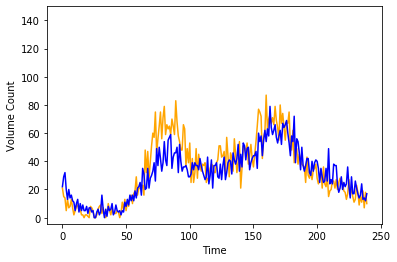

In [25]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata.csv', header=0, index_col=None)
#print (dataset_original)
## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
#print (dataset_original)
dataset_original = dataset_orginal[:-240]
#print (dataset_original)
dataset_original=dataset_original[dataset_original['date_time'].str.contains("3/18/2019")==True]

#extract State-EB-L_1 series for 18th March
#series_18march = dataset_original['State-EB-L_1'].values
series_18march = dataset_original[['Luckie-WB-L_1','Peachtree-SB-L_1']].values
time_18march = dataset_original['date_time'].values

time_num_18march = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_18march, series_18march[:,0], color='orange')
plt.plot(time_num_18march, series_18march[:,1], color='blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

(-4.3500000000000005, 150)

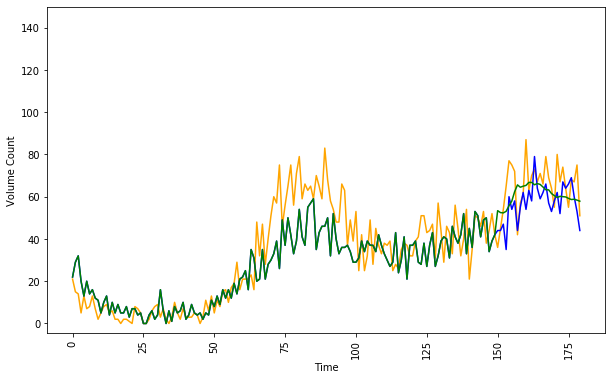

In [26]:
##apply model to the 18th march data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_18march[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 30
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
    p = [[series_18march[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)


#forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
#print (sliced_val_series)

sliced_val_actual = series_18march[:slice_val_time+number_missing_units] 
sliced_val_times = time_18march[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=150)

In [28]:
print (sliced_val_actual)
print (sliced_val_series)
actuals = sliced_val_actual[:,1][-30:]
predictions = sliced_val_series[:,1] [-30:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals-predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

# actuals = 
# predictions = 
# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[[21. 22.]
 [15. 29.]
 [14. 32.]
 [ 5. 20.]
 [13. 13.]
 [ 7. 20.]
 [ 8. 14.]
 [13. 16.]
 [ 7. 12.]
 [ 2. 11.]
 [ 5.  5.]
 [ 8. 10.]
 [ 9. 13.]
 [ 5.  4.]
 [ 6. 10.]
 [ 2.  5.]
 [ 2.  9.]
 [ 0.  5.]
 [ 2.  5.]
 [ 2.  8.]
 [ 1.  3.]
 [ 0.  7.]
 [ 8.  7.]
 [ 7.  4.]
 [ 5.  5.]
 [ 0.  0.]
 [ 0.  0.]
 [ 2.  4.]
 [ 6.  6.]
 [ 8.  2.]
 [ 9.  4.]
 [ 3. 16.]
 [ 7.  6.]
 [ 2.  0.]
 [ 0.  6.]
 [ 3.  1.]
 [10.  8.]
 [ 5.  5.]
 [ 2.  6.]
 [ 7. 10.]
 [ 3.  2.]
 [ 3.  4.]
 [ 3.  9.]
 [ 5.  5.]
 [ 4.  4.]
 [ 0.  5.]
 [ 3.  2.]
 [11.  5.]
 [ 6.  4.]
 [13. 11.]
 [ 5.  8.]
 [11. 13.]
 [ 8.  9.]
 [15. 16.]
 [16. 12.]
 [10. 16.]
 [17. 12.]
 [19. 19.]
 [29. 14.]
 [16. 21.]
 [21. 22.]
 [21. 25.]
 [21. 16.]
 [23. 35.]
 [16. 31.]
 [48. 20.]
 [32. 21.]
 [47. 35.]
 [28. 21.]
 [40. 28.]
 [51. 30.]
 [60. 33.]
 [57. 39.]
 [75. 26.]
 [46. 49.]
 [56. 37.]
 [65. 50.]
 [75. 42.]
 [56. 33.]
 [71. 39.]
 [79. 54.]
 [59. 41.]
 [66. 37.]
 [63. 55.]
 [65. 57.]
 [59. 59.]
 [70. 35.]
 [65. 43.]
 [59. 46.]
 [83. 46.]
 [68. 50.]

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_peachtree_sb_l1_multivariate_18mar.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_peachtree_sb_l1_multivariate_18mar.csv")

## Model Performance on 27 May (Memorial Day) for Simulation Experiment

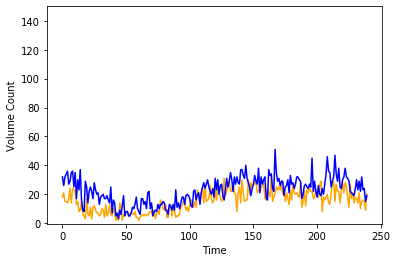

In [29]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("5/27/2019")==True]

#extract State-EB-L_1 series for 27th May
#series_18march = dataset_original['State-EB-L_1'].values
series_27may = dataset_original[['Luckie-WB-L_1','Peachtree-SB-L_1']].values
time_27may = dataset_original['date_time'].values

time_num_27may = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_27may, series_27may[:,0], color='orange')
plt.plot(time_num_27may, series_27may[:,1], color='blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

#print (series_27may)

(-0.4500000000000002, 150)

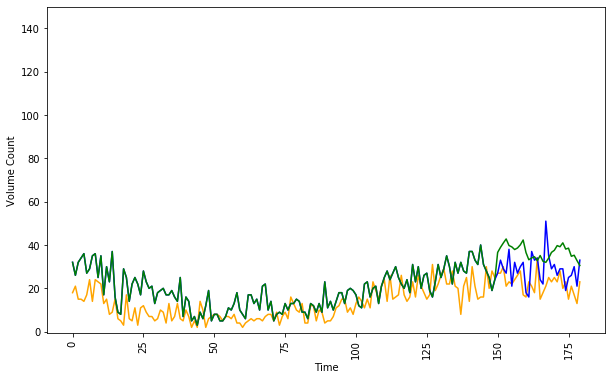

In [30]:
##apply model to the 27 May data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_27may[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 30
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))

    p = [[series_27may[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    #p = [sliced_val_series,p]
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)
    #forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
# print (sliced_val_series)
# print (sliced_val_actual)
sliced_val_actual = series_27may[:slice_val_time+number_missing_units] 
sliced_val_times = time_27may[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=150)

In [31]:
print (sliced_val_actual)
print (sliced_val_series)
actuals = sliced_val_actual[:,1][-30:]
predictions = sliced_val_series[:,1] [-30:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals-predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[[18. 32.]
 [21. 26.]
 [15. 32.]
 [15. 34.]
 [14. 36.]
 [17. 27.]
 [24. 29.]
 [14. 35.]
 [24. 36.]
 [23. 25.]
 [22. 35.]
 [13. 17.]
 [15. 30.]
 [ 8. 23.]
 [ 9. 37.]
 [15. 16.]
 [ 6.  9.]
 [ 5.  8.]
 [ 3. 29.]
 [17. 25.]
 [ 6. 14.]
 [ 5. 22.]
 [11. 25.]
 [ 3. 22.]
 [11. 17.]
 [12. 28.]
 [ 9. 23.]
 [ 7. 20.]
 [ 7. 21.]
 [ 5. 13.]
 [ 6. 18.]
 [10. 19.]
 [ 9. 20.]
 [ 4. 17.]
 [13. 17.]
 [ 5. 19.]
 [ 7. 16.]
 [13. 14.]
 [ 6. 25.]
 [ 5.  7.]
 [10. 16.]
 [ 7. 14.]
 [ 2.  5.]
 [ 5.  7.]
 [ 2.  3.]
 [14.  9.]
 [10.  6.]
 [ 2. 12.]
 [ 6. 19.]
 [ 7.  5.]
 [ 8.  8.]
 [ 8.  8.]
 [ 7.  5.]
 [ 5.  5.]
 [ 7.  7.]
 [ 7. 11.]
 [ 6. 10.]
 [ 8. 13.]
 [ 4. 18.]
 [ 4. 10.]
 [ 2.  8.]
 [ 4.  6.]
 [ 5. 17.]
 [ 6. 17.]
 [ 5. 13.]
 [ 6. 15.]
 [ 6. 10.]
 [ 5. 21.]
 [ 7. 22.]
 [ 8. 10.]
 [ 8. 14.]
 [ 5.  5.]
 [ 9.  8.]
 [ 3.  9.]
 [ 7.  8.]
 [ 9. 13.]
 [ 6. 10.]
 [16. 13.]
 [13. 13.]
 [10. 15.]
 [ 9. 14.]
 [13.  9.]
 [ 4.  9.]
 [ 4.  6.]
 [12. 13.]
 [12. 12.]
 [ 5.  9.]
 [10. 13.]
 [ 9.  9.]
 [ 4. 23.]
 [ 5. 11.]

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_peachtree_sb_l1_multivariate_27may.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_peachtree_sb_l1_multivariate_27may.csv")